# Counting DL and DLT histories: paper figures
### Cedric Chauve, 01/02/2019

## Introduction

This notebook contains the code used to analyse our experimental results and generate the figure in the paper.

In [4]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import math

In [40]:
# Parameters

# Number of species trees per size
NB_S_TREES    = 100
S_TREES_INDEX = [i for i in range(0,NB_S_TREES)]
# Evolutionary models
EVOL_MODELS = [('U','DL'),('U','DLT'),('R','DL'),('R','DLT')]
# Species tree sizes
K_MIN = 3
K_MAX = 32
K_LIST = [k for k in range(K_MIN,K_MAX+1)]
# Histories sizes
N_MIN = 1
N_MAX = 50
N_LIST = [n for n in range(N_MIN,N_MAX+1)]
# Paths to results
PREFIX_UNRANKED    = '../../exp/09-01-2019-exp1-redone/results/exp1a'
PREFIX_RANKED      = '../../exp/01-02-2019-exp1-ranking/results/exp1'
PREFIX_ASYMPTOTICS = '../../exp/29-01-2019-exp1-redone-2/systems/exp1a'

In [41]:
# TMP
K_MIN = 3
K_MAX = 5
K_LIST = [k for k in range(K_MIN,K_MAX+1)]

In [42]:
# Reading the exact counting results
# Format: RESULTS_ALL[evol_model][s][n][tree_index] is 
# the list of the number of histories of size n for tree tree_index of size s in model evol_model 
# the list is of size 1 if the tree is unranked

RESULTS_aux = {m:{s:{n:{t:[] for t in S_TREES_INDEX} for n in N_LIST}  for s in K_LIST} for m in EVOL_MODELS}
    
def read_counting_file(fileName,k):
    with gzip.open(fileName, 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0]!='#':
                model     = (row[2],row[3])
                treeIndex = int(row[1])
                row5      = row[5].split()
                for n in N_LIST:
                    RESULTS_aux[model][k][n][treeIndex].append(int(row5[n-1]))
    
for k in K_LIST:
    read_counting_file(PREFIX_UNRANKED+'_'+str(k)+'.gz',k)
    read_counting_file(PREFIX_RANKED+'_'+str(k)+'.gz',k)
                            
RESULTS_COUNTING = pd.DataFrame.from_dict({(m,k,n): RESULTS_aux[m][k][n]
                                            for m in RESULTS_aux.keys() 
                                            for k in RESULTS_aux[m].keys()
                                            for n in RESULTS_aux[m][k].keys()},
                                            orient='index')

In [51]:
# Reading the asymptotics results for the model (U,DL)

RESULTS_aux = {('U','DL'):{k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}}
for k in K_LIST:
    dataAsympt = open(PREFIX_ASYMPTOTICS+'_'+str(k)+'_asy').readlines()
    for row in dataAsympt:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            asymptotics =  float(row1[2])
            RESULTS_aux[('U','DL')][k][treeIndex] = asymptotics
RESULTS_ASYMPTOTICS = pd.DataFrame.from_dict({(m,k): RESULTS_aux[m][k]
                                                for m in RESULTS_aux.keys() 
                                                for k in RESULTS_aux[m].keys()},
                                                orient='index')

In [52]:
RESULTS_ASYMPTOTICS

0          1          2          3          4          5   \
(U, DL) 3  15.722796  15.722796  15.722796  15.722796  15.722796  15.722796   
        4  22.687279  20.753034  20.753034  22.687279  20.753034  20.753034   
        5  30.527541  26.934364  26.934364  26.934364  30.527541  26.934364   

                  6          7          8          9     ...             90  \
(U, DL) 3  15.722796  15.722796  15.722796  15.722796    ...      15.722796   
        4  22.687279  20.753034  22.687279  20.753034    ...      20.753034   
        5  30.527541  29.038330  30.527541  26.934364    ...      29.038330   

                  91         92         93         94         95         96  \
(U, DL) 3  15.722796  15.722796  15.722796  15.722796  15.722796  15.722796   
        4  22.687279  20.753034  22.687279  22.687279  20.753034  22.687279   
        5  29.038330  26.934364  30.527541  26.934364  29.038330  29.038330   

                  97         98         99  
(U, DL) 3  15.722796  15.722796  15.722796  
        4  20.753034  22.687279  22.687279  
        5  30.527541  26.934364  26.934364  

[3 rows x 100 columns]

In [94]:
RATIOS_ALL                          = RESULTS_1_ALL.applymap(lambda x: max(x)/min(x))
RATIOS_ALL_AVG_STD                  = pd.concat([pd.DataFrame(RATIOS_ALL.mean(axis=1),columns=['max/min:avg']), pd.DataFrame(RATIOS_ALL.std(axis=1),columns=['max/min:std'])], axis=1)

<Figure size 432x288 with 0 Axes>

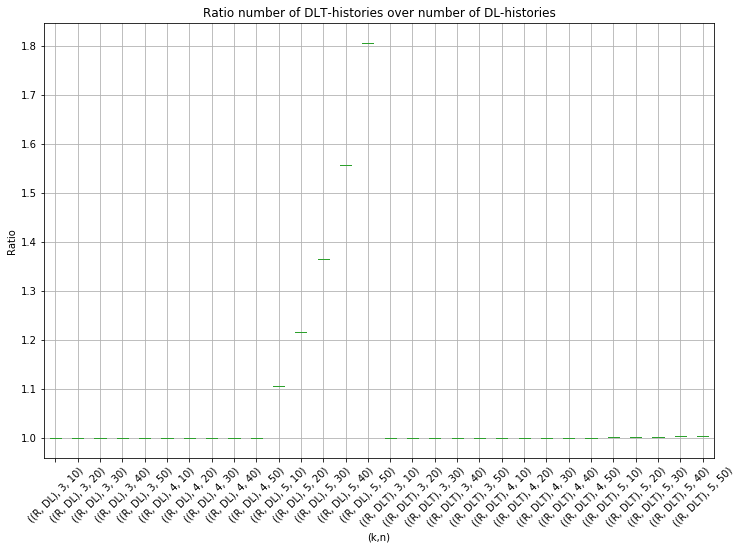

In [127]:
# Creating boxplots

plt.figure()
ax1 = pd.DataFrame(RATIOS_ALL_AVG_STD['max/min:avg']).transpose().plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Ratio number of DLT-histories over number of DL-histories')
ax1.set_ylabel('Ratio')
ax1.set_xlabel('(k,n)')
plt.xticks(rotation=45)
plt.savefig('ratio_DLT_DL.png')
plt.show()